# TURS vs. my method

In [1]:
import pandas as pd

import capnp
capnp.remove_import_hook()
interface_capnp = capnp.load("../../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

import sys
sys.path.append("../..")
from experiments.evaluation import Evaluator
from experiments.modelgeneration import ModelGenerator

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /root/.vscode-server/bin/b7886d7461186a5eac768481578c1d7ca80e2d21


In [2]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdatesCpp = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [3]:
client = capnp.TwoPartyClient("turs:21653")
processDataUpdatesTurs = client.bootstrap().cast_as(interface_capnp.SimpleProcessDataUpdates)

In [4]:
# initialize objects
evaluator = Evaluator(interface_capnp, processDataUpdatesCpp)
modelGen = ModelGenerator(interface_capnp, processDataUpdatesCpp, processDataUpdatesTurs)

In [5]:
metrics = ["strictF1", "looseF1", "complexity", "valueSetF1"]

## Individual test

### Generate event log

In [5]:
!capnp convert json:binary ../../cpp-tool/capnproto/interface.capnp RuleModel < tursModel.json > /tmp/tursModel.bin
with open("/tmp/tursModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdatesCpp.modelToString(model).wait().string)

IF light = red THEN color IN {blue}
IF binary = True THEN color IN {black}
IF paint = orange THEN light IN {yellow}
IF paint = purple THEN light IN {green}



In [6]:
logWithUsage = processDataUpdatesCpp.generateEventLog(model=model, numberOfTraces=100, traceLength=20).wait()
log = logWithUsage.log
ruleUsage = logWithUsage.ruleUsage

In [7]:
updateRules = [x.rule.updateRule for x in ruleUsage]
frequencies = [x.frequency for x in ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "light",\n  valueSetRule = (set =...        516
1  ( variable = "light",\n  valueSetRule = (set =...        474
2  ( variable = "color",\n  valueSetRule = (set =...        258
3  ( variable = "color",\n  valueSetRule = (set =...        948

### Add noise

In [6]:
from experiments.addnoise import addSwapNoiseToMessage
noisyLog = addSwapNoiseToMessage(log, proportion=0.1)

Constructing traces: 100%|██████████| 100/100 [00:00<00:00, 1954.41it/s]


### Find model with my method

In [7]:
cppModel = processDataUpdatesCpp.findModel(noisyLog).wait().model
print(processDataUpdatesCpp.modelToString(cppModel).wait().string)

IF NOT (color = black) THEN binary IN {False}
IF light = red THEN color IN {blue}
IF paint = purple THEN light IN {green}
IF light = red THEN binary IN {True}
IF paint = orange THEN light IN {yellow}



### Find model with TURS

In [10]:
tursModel = processDataUpdatesTurs.findModel(noisyLog).wait().model
tursModel = modelGen.removeCyclicRules(tursModel)
print(processDataUpdatesCpp.modelToString(tursModel).wait().string)

IF color = black THEN binary IN {True}
IF ((paint = orange) OR ((paint = blue) OR (paint = black))) AND (((color = purple) OR (color = orange)) AND (((light = yellow) OR (light = green)) AND ((color = purple) OR ((color = orange) OR (color = blue))))) THEN binary IN {False}
IF (color = orange) AND ((paint = purple) AND (((color = purple) OR ((color = orange) OR (color = blue))) AND ((light = yellow) OR (light = green)))) THEN binary IN {False}
IF ((color = purple) OR (color = blue)) AND ((light = yellow) OR (light = green)) THEN binary IN {False}
IF paint = purple THEN light IN {green}
IF ((paint = orange) OR ((paint = blue) OR (paint = black))) AND (((paint = purple) OR (paint = orange)) AND ((color = purple) OR ((color = orange) OR (color = black)))) THEN light IN {yellow}
IF ((paint = orange) OR ((paint = blue) OR (paint = black))) AND ((color = blue) AND ((paint = purple) OR ((paint = blue) OR (paint = black)))) THEN light IN {red}
IF ((color = purple) OR ((color = blue) OR (color 

Weirdly, TURS finds conditions that are inherently redundant and unnecessarily long e.g. `((paint = orange) OR ((paint = blue) OR (paint = black))) AND ((paint = purple) OR (paint = orange))` can be reduced to `paint = orange`.

### Compute metrics

In [11]:
evaluator.computeF1Score(model, cppModel)

0.6666666666666665

In [12]:
evaluator.computeF1Score(model, tursModel)

0.16666666666666666

## Systematic model generation

In [15]:
import os
import shutil

# clean start for the experiment
experimentName = "tursNoiseVariation"
shutil.rmtree(experimentName, ignore_errors=True)
os.mkdir(experimentName)

# generate and save ground-truth models (and empty models)
trueModels = modelGen.generateTrueModels()
modelGen.saveTrueModels(experimentName, trueModels)
modelGen.saveEmptyModels(experimentName, trueModels)

In [ ]:
modelGen.generateModelEstimates(experimentName, trueModels, [0.0, 0.1, 0.2, 0.3, 0.4], [2000], 10)

## Evaluating experiments

In [5]:
noiseTable = evaluator.createExperimentTable("tursNoiseVariation",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-(.+)-model\.bin",
    ["noiseProportion", "logLength", "modelID", "logVariant", "method"])
samplesTable = evaluator.createExperimentTable("tursSampleVariation",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-(.+)-model\.bin",
    ["noiseProportion", "logLength", "modelID", "logVariant", "method"])

In [6]:
evaluator.addMetricsToExperimentTable("tursNoiseVariation", noiseTable, metrics)
evaluator.addMetricsToExperimentTable("tursSampleVariation", samplesTable, metrics)

Computing valueSetF1: 100%|██████████| 1220/1220 [12:24<00:00,  1.64it/s]


In [7]:
noiseTable.to_csv("tursNoiseTable.csv")
samplesTable.to_csv("tursSamplesTable.csv")

## Visualizing experiments

In [6]:
noiseTable = pd.read_csv("tursNoiseTable.csv")
samplesTable = pd.read_csv("tursSamplesTable.csv")

In [7]:
# fix datatypes
noiseTable.logLength = pd.to_numeric(noiseTable.logLength)
noiseTable.noiseProportion = pd.to_numeric(noiseTable.noiseProportion)
samplesTable.logLength = pd.to_numeric(samplesTable.logLength)
samplesTable.noiseProportion = pd.to_numeric(samplesTable.noiseProportion)

In [8]:
# aggregate data for plot
aggregationColumns = ["logLength", "noiseProportion", "method"]
noiseAggregated = evaluator.aggregateMetrics(noiseTable, aggregationColumns, metrics)
samplesAggregated = evaluator.aggregateMetrics(samplesTable, aggregationColumns, metrics)

### Plots

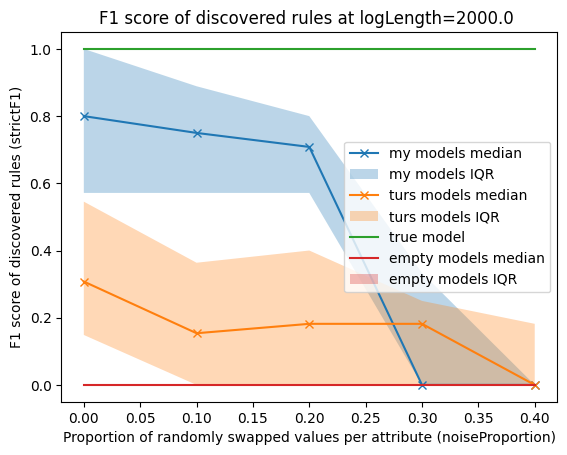

In [9]:
evaluator.plotScoreWithIqr(noiseAggregated, "strictF1", "noiseProportion", ["logLength"])

In [10]:
evaluator.plotScoreWithIqr(noiseAggregated, "looseF1", "noiseProportion", ["logLength"])

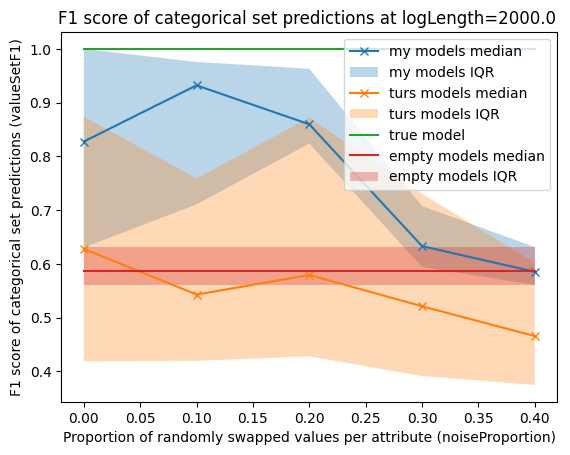

In [11]:
evaluator.plotScoreWithIqr(noiseAggregated, "valueSetF1", "noiseProportion", ["logLength"])

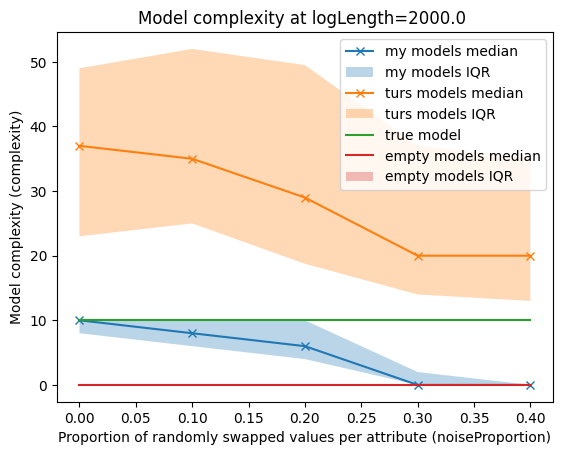

In [12]:
evaluator.plotScoreWithIqr(noiseAggregated, "complexity", "noiseProportion", ["logLength"])

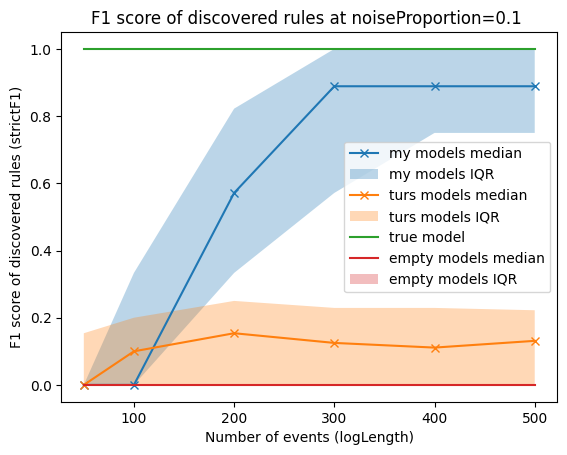

In [13]:
evaluator.plotScoreWithIqr(samplesAggregated, "strictF1", "logLength", ["noiseProportion"])

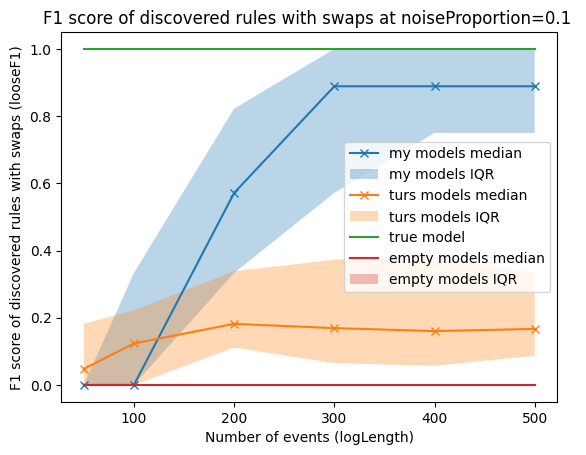

In [14]:
evaluator.plotScoreWithIqr(samplesAggregated, "looseF1", "logLength", ["noiseProportion"])

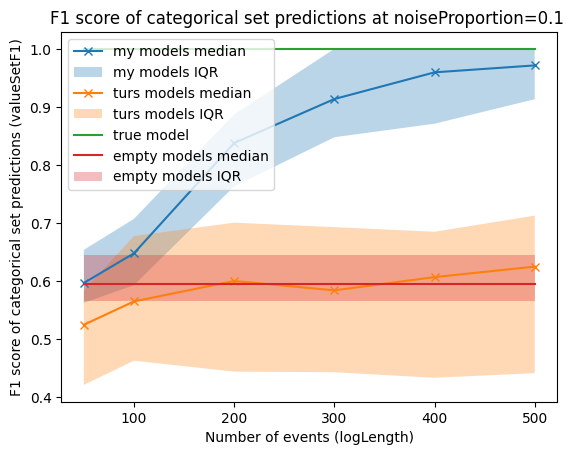

In [15]:
evaluator.plotScoreWithIqr(samplesAggregated, "valueSetF1", "logLength", ["noiseProportion"])

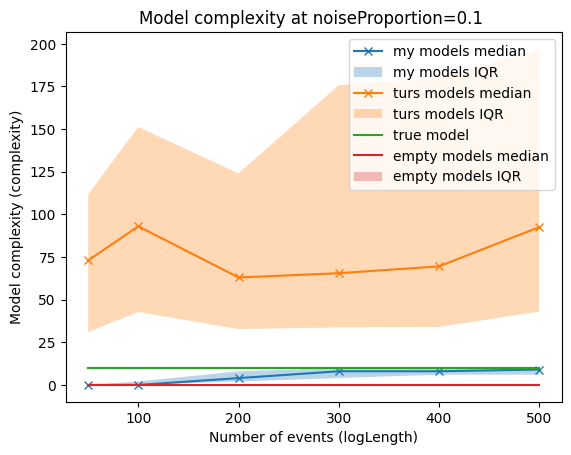

In [16]:
evaluator.plotScoreWithIqr(samplesAggregated, "complexity", "logLength", ["noiseProportion"])

### LaTeX exports

In [21]:
def extractMetricForPgfplots(aggregatedTable, metricName, fileName):
    metric = aggregatedTable[metricName]
    metric = metric.drop(0.4, level=1, axis="index", errors="ignore")
    metric["lowIqr"] = metric["midIqr"] - metric["lowIqr"]
    metric["highIqr"] = metric["highIqr"] - metric["midIqr"]
    metric = metric.rename(columns={"lowIqr": "relative lowIqr", "highIqr": "relative highIqr"})
    metric.to_csv("../../document/figs/" + fileName)

In [22]:
extractMetricForPgfplots(noiseAggregated, "looseF1", "loose-f1-noise-vs-turs.csv")

In [23]:
extractMetricForPgfplots(noiseAggregated, "valueSetF1", "prediction-f1-noise-vs-turs.csv")

In [24]:
extractMetricForPgfplots(noiseAggregated, "complexity", "complexity-noise-vs-turs.csv")

In [25]:
extractMetricForPgfplots(samplesAggregated, "looseF1", "loose-f1-samples-vs-turs.csv")